In [1]:
# import the libraries
import eli5 # experimental library: pip install eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display

from keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
plt.style.use('ggplot')

import numpy as np
from sklearn.utils import shuffle
from numpy import array
from numpy import count_nonzero

# For keras
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.models import load_model
from keras import optimizers

# For metrics
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Confusion matrix and classification reports
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Data ingestion

In [7]:
import chardet # only for CSV file
path = 'C:/Users/v-docu/OneDrive/_Python/ALL PYTHON/TenantReduced4.csv' # best performance
# checking the encoding
with open(path, 'rb') as data:
    result = chardet.detect(data.read(1000))
print(result)

# reading the csv
df = pd.read_csv(path, encoding = 'ascii')
print('Data shape:',df.shape)
df.head()

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
Data shape: (162321, 12)


,TenantId,IsEDU,IsNonProfIt,IsGov,EntitlementSeatBucket,TopParentsCount,FinalIndustry,FinalVertical,ServiceName,TenantAgeBucket,Country,BInaryUser
0,746f7b08-a7f8-47c0-a63c-819f3f0cdef8,0,0,0,Unknown,1,Unknown,Unknown,Unknown,Unknown,Japan,0
1,9f29da19-c187-43fa-a979-3511955832e7,0,0,0,3.50-149,2,ChemIcals & AgrochemIcals,ChemIcals,SharePoInt,365+,CzechRepublIc,1
2,9f29da19-c187-43fa-a979-3511955832e7,0,0,0,4.150-249,2,ChemIcals & AgrochemIcals,ChemIcals,SfB(Skype for BusIness),365+,CzechRepublIc,1
3,9f29da19-c187-43fa-a979-3511955832e7,0,0,0,1.0-9,2,ChemIcals & AgrochemIcals,ChemIcals,Exchange,365+,CzechRepublIc,1
4,9f29da19-c187-43fa-a979-3511955832e7,0,0,0,4.150-249,2,ChemIcals & AgrochemIcals,ChemIcals,Teams,365+,CzechRepublIc,1


### Data transformation - categorical to numerical

In [8]:
# separating data from labels
def df_to_data_labels(df):
    data = df.iloc[:, 1:-1] # 1st column is TenantId - not needed
    labels = df.iloc[:,-1]
    
    # categorical columns to dummies
    to_dummies = ['EntitlementSeatBucket','TopParentsCount', 'FinalIndustry', 'FinalVertical', 'ServiceName','TenantAgeBucket', 'Country' ]
    x = pd.get_dummies(data = data, columns = to_dummies)
    columns = x.columns
    
    #removing the headers - keeping only the data
    x0 = x.values 
    y0 = labels.values
    return x0, y0, columns
x0,y0,feature_columns = df_to_data_labels(df)

Original data shape (rows, cols):  (162321, 10)

Transformed data shape (rows,cols):  (162321, 364)


### Data transformation - train, test split

We're splitting the data three ways:

    - training set
    - validation set
    - testing set
    

In [14]:
def train_test(x0,y0):
    # shuffle the data so we're getting the datapoints randomized
    x0, y0 = shuffle(x0,y0)
    print('\nSplitting the data...')
    X_train, X_test, y_train, y_test = train_test_split(x0,y0, test_size = .3, random_state = 42)  
    return  X_train, X_test, y_train, y_test

x0,y0,feature_columns = df_to_data_labels(df) # feature_columns is type <class 'pandas.core.indexes.base.Index'>
X_train, X_test, y_train, y_test = train_test(x0,y0)
X_train, X_Val, y_train, y_val = train_test_split(X_train, y_train, test_size = .2, random_state = 42 )

print('\nTraining set:: ', X_train.shape)
print('Validation set: ', X_Val.shape)
print('Testing set: ', X_test.shape)  

Original data shape (rows, cols):  (162321, 10)

Transformed data shape (rows,cols):  (162321, 364)

Splitting the data...

Trainin set::  (90899, 364)
Validation set:  (22725, 364)
Testing set:  (48697, 364)


### Data modelling

In [16]:
# ANN specs
epoch = 5
bs = 2500 # batch size
n_cols = x0.shape[1]

#### Create ANN model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              747520    
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dense_7 (Dense)              (None, 20)                20020     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 63        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 4         
Total params: 2,816,607
Trainable params: 2,816,607
Non-trainable params: 0
_________________________________________________________________
Train on 90899 samples, validate on 22725 samples
Epoch 1/5
90899/90899 [==============================] - 59s 654us/step - loss: 0.

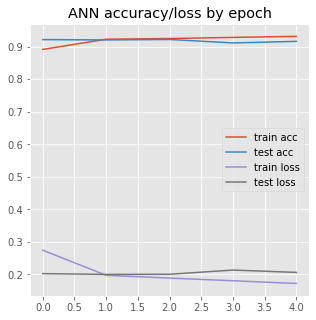

In [35]:
def keras_classifier(x, y, epochs = epoch, batch_size = bs,  validation_data=(X_Val, y_val)):
        
    model = Sequential()
    # DENSE LAYERS
    model.add(Dense(2048, activation = 'relu', input_shape = (n_cols,))) # Final architecture w 2000 neurons
    model.add(Dense(1000, activation = 'relu')) # new layer for Jupyter
    model.add(Dense(20, activation = 'relu')) # Final architecture
    model.add(Dense(3, activation = 'relu')) # Final architecture
    model.add(Dense(1, activation = 'sigmoid')) # Final architecture
        
    # COMPILING THE MODEL - OPTIMIZATION
    #adam = optimizers.Adam(lr=0.0012, beta_1=0.9, beta_2=0.997, epsilon=None, decay=0.0007, amsgrad=True)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) 
    model.summary()
    r = model.fit(x, y, epochs = epoch, batch_size = bs, validation_data=(X_Val, y_val))
    #score = model.evaluate(X_Val, y_val)
    plt.figure(figsize=(5,5))
    plt.plot(r.history['acc'], label='train acc') 
    plt.plot(r.history['val_acc'], label='test acc') 
    plt.plot(r.history['loss'], label='train loss')
    plt.plot(r.history['val_loss'], label='test loss')
    plt.legend()
    plt.title('ANN accuracy/loss by epoch')
    plt.show()
    return model
    
    
clf = keras_classifier(X_train, y_train,  validation_data=(X_Val, y_val))

#### Save the model

In [36]:
# Saving the model
model_name = 'keras_classifier_tenants_shallow0'
    
def model_save(name):
    return clf.save(name)
    
model_save(model_name)
print('model saving complete')

model saving complete


#### Load the model

In [37]:
# Loading the model
model_name = 'keras_classifier_tenants_shallow0'
    
def model_load(name):
    return load_model(name) 
        
clf = model_load(model_name)
print('model loading complete')


model loading complete


### ANN metrics



TRAIN -- CONFUSION MATRIX:

Training set CONFUSION MATRIX:
 [[35944  7617]
 [    0 47338]] 




TEST -- CONFUSION MATRIX, Effective Targetting Accuracy: 



Test set CONFUSION MATRIX:
 [[19074  4083]
 [    9 25531]] 


Effective Targetting Accuracy
of unseen data:  99.981518368688 %


TEST -- RECALL, PRECISION, F1 scores:

Test set PRECISION score 92.747 %
Test set RECALL score 91.597 %
Test set F1 score 91.5021 %
Test set F1 (doublecheck): 92.168 %
Test AUC: 91.166 % 




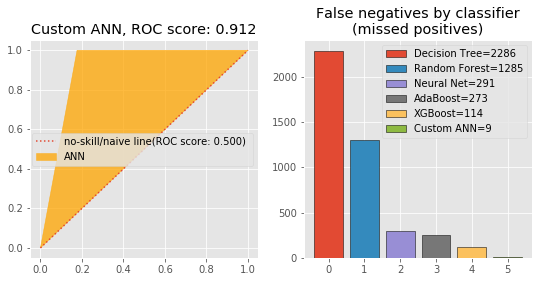

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     23157
           1       0.86      1.00      0.93     25540

   micro avg       0.92      0.92      0.92     48697
   macro avg       0.93      0.91      0.91     48697
weighted avg       0.93      0.92      0.92     48697



In [51]:
threshold = 0.02

def ANN_metrics():
    # TRAIN recall, precision, F1 scores 
    print('\n\nTRAIN -- CONFUSION MATRIX:\n')
    y_true = y_train
    y_pred = clf.predict(X_train)
    y_pred[y_pred < threshold] = 0 # .34 for regular model; .05 for the shallow model
    y_pred[y_pred >= threshold] = 1 # .34 for regular model; .05 for the shallow model
    
    cm_train = confusion_matrix(y_train, y_pred)
    print('Training set CONFUSION MATRIX:\n', cm_train,'\n\n')
    
    # TEST recall, precision, F1 scores
    print('\n\nTEST -- CONFUSION MATRIX, Effective Targetting Accuracy:','\n')
    y_true = y_test
    y_pred = clf.predict(X_test)
    y_pred[y_pred < threshold] = 0 # .34 for regular model; .05 for the shallow model
    y_pred[y_pred >= threshold] = 1 # .34 for regular model; .05 for the shallow model
    
    cm_test = confusion_matrix(y_test, y_pred)
    print('\n\nTest set CONFUSION MATRIX:\n', cm_test,'\n\n')  
     # False negatives
    fn = cm_test[1,0]
    sum_all = cm_test.sum()

    # Effective targetting accuracy
    eta = (1 - fn/sum_all)*100
    print('Effective Targetting Accuracy\nof unseen data: ', eta, '%\n')
        
    # TEST recall, precision, F1 scores
    print('\nTEST -- RECALL, PRECISION, F1 scores:\n')
    recall = metrics.recall_score(y_true, y_pred, average = 'weighted')
    precision = metrics.precision_score(y_true, y_pred, average = 'weighted')
    print('Test set PRECISION score %.3f'%(precision*100), '%')
    print('Test set RECALL score %.3f'%(recall*100), '%')
    F1 = metrics.f1_score(y_true, y_pred, average = 'weighted')
    print('Test set F1 score %.4f'%(F1*100),'%')
    F1_2 = 2*(recall*precision)/(recall + precision)
    print('Test set F1 (doublecheck): %.3f' %(F1_2*100),'%')
    
    # calculate AUC
    auc = roc_auc_score(y_test, y_pred)
    print('Test AUC: %.3f' % (auc*100),'%','\n\n')
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    # plot no skill
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    plt.title('Custom ANN, ROC score: %.3f'%auc)
    plt.plot([0, 1], [0, 1], linestyle=':', label='no-skill/naive line(ROC score: 0.500) ')
    # plot the roc curve for the model
    plt.fill(fpr, tpr,label = 'ANN', alpha = .75, color = 'orange')#  marker='.', 
    plt.legend()
    
    # plot the FN data
    plt.subplot(1, 2, 2)
    plt.title('False negatives by classifier\n(missed positives)')
    plt.bar(x =0, height = 2286, label = ('Decision Tree' + '=' + str(2286)), edgecolor = 'k')
    plt.bar(x =1, height = 1297, label = ('Random Forest' + '=' + str(1285)), edgecolor = 'k')
    plt.bar(x =2, height = 291, label = ('Neural Net' + '=' + str(291)), edgecolor = 'k')
    plt.bar(x =3, height = 254, label = ('AdaBoost' + '=' + str(273)), edgecolor = 'k')
    plt.bar(x =4, height = 114, label = ('XGBoost' + '=' + str(114)), edgecolor = 'k')
    plt.bar(x =5, height = fn, label = ('Custom ANN' + '=' + str(fn)), edgecolor = 'k')
    #plt.ylim(0,50)
    plt.legend()
    plt.show()
    
    # CLASSIFICATION REPORT
    class_report = classification_report(y_true, y_pred)
    print(class_report)

ANN_metrics()

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
    
X_train = pca.fit_transform(X_train)
X_Val = pca.fit_transform(X_Val)
X_test = pca.fit_transform(X_test)
        
print('\nTraining set size after dim reduction: ', X_train.shape)
print('Validation set size after dim reduction: ', X_Val.shape)
print('Testing set size after dim reduction: ', X_test.shape)


Training set size after dim reduction:  (90899, 2)
Validation set size after dim reduction:  (22725, 2)
Testing set size after dim reduction:  (48697, 2)



Training the dimensionality reduced sets...

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2048)              6144      
_________________________________________________________________
dense_11 (Dense)             (None, 1000)              2049000   
_________________________________________________________________
dense_12 (Dense)             (None, 20)                20020     
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 63        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 4         
Total params: 2,075,231
Trainable params: 2,075,231
Non-trainable params: 0
_________________________________________________________________
Train on 90899 samples, validate on 22725 samples
Epoch 1/2
90899/90899 [=============

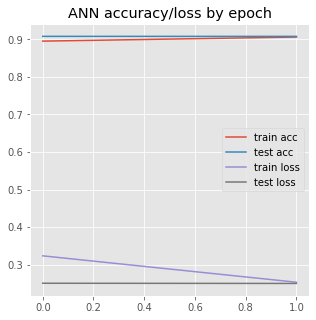

pca model saving complete
model loading complete


In [53]:
# ANN specs
epoch = 2
bs = 2750
n_cols = X_train.shape[1]
        
print('\nTraining the dimensionality reduced sets...\n')
clf = keras_classifier(X_train, y_train,  validation_data=(X_Val, y_val))
        
        
pca_model = 'pca_data_model3'
        
def model_save(name):
    return clf.save(name)
        
model_save(pca_model)
print('pca model saving complete')
        
        
# Loading a model
model_name = 'pca_data_model3'
        
def model_load(name):
    return load_model(name) 
            
clf = model_load(model_name)
print('model loading complete')

[]

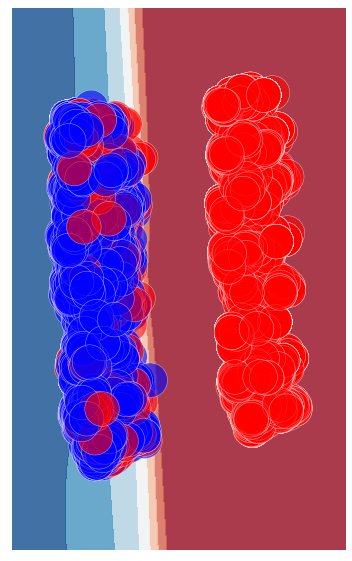

In [56]:
DIA = 1200
eta = 0.9999179268317705
        
h = .02  # step size in the mesh
        
x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
        
        
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])#[:, 1]
        
# Put the result into a color plot
from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        
plt.figure(figsize = (6, 10))
ax = plt.subplot(111)
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
        
# Plot also the training points
#ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,edgecolors='k')
        
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=DIA, cmap=cm_bright,edgecolors='w', alpha=0.6)
        
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())